In [1]:
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = ('/content/drive/MyDrive/AAI521/archive/annotations')

In [4]:
image_path= ('/content/drive/MyDrive/AAI521/archive/images')

In [5]:
# Function to parse an XML file and extract annotations
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    annotations = []

    for member in root.findall('object'):
        label = member.find('name').text
        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        annotations.append({'label': label, 'bbox': [xmin, ymin, xmax, ymax]})

    filename = root.find('filename').text
    return filename, annotations

In [6]:
# Function to preprocess a single image and its annotations for a fixed size of 300x300
def preprocess_image_annotation(image_path, annotation_list, target_size=(300, 300)):
    # Load the image
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure image is in RGB format

    # Original size
    original_size = image.size

    # Resize image to 600x600
    image = image.resize(target_size)

    # Normalize the pixel values to be between 0 and 1
    image_array = np.array(image) / 255.0

    # Scale the bounding box annotations
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]
    scaled_annotations = []
    for ann in annotation_list:
        scaled_bbox = [int(ann['bbox'][0] * scale_x), int(ann['bbox'][1] * scale_y),
                       int(ann['bbox'][2] * scale_x), int(ann['bbox'][3] * scale_y)]
        scaled_annotations.append({'label': ann['label'], 'bbox': scaled_bbox})

    return image_array, scaled_annotations

In [7]:
# Paths to the annotations and images folders
annotations_dir = ('/content/drive/MyDrive/AAI521/archive/annotations')
images_dir = ('/content/drive/MyDrive/AAI521/archive/images')


In [8]:
# List all XML files in the annotations directory
xml_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]

In [9]:
# Preprocess all images and annotations
preprocessed_data = []
for xml_file in xml_files:
    # Parse annotations
    filename, annotations = parse_xml(os.path.join(annotations_dir, xml_file))

    # Corresponding image path
    image_filename = filename.replace('.xml', '.png')  # Ensure the extension matches your image files
    image_path = os.path.join(images_dir, image_filename)

    # Preprocess image and annotations
    image_array, scaled_annotations = preprocess_image_annotation(image_path, annotations)

    # Store in the list
    preprocessed_data.append({'image': image_array, 'annotations': scaled_annotations})


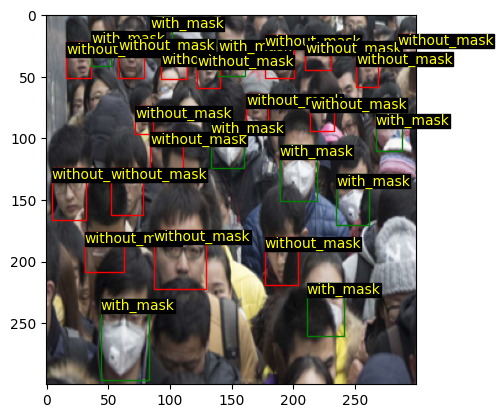

In [10]:
# Visualize one example
sample_image_data = preprocessed_data[0]['image']
sample_annotations = preprocessed_data[0]['annotations']
plt.imshow(sample_image_data)
for ann in sample_annotations:
    bbox = ann['bbox']
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                             linewidth=1, edgecolor='r' if ann['label'] == 'without_mask' else 'g',
                             facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(bbox[0], bbox[1], ann['label'], color='yellow', verticalalignment='top',
             bbox={'color': 'black', 'pad': 0})
plt.show()

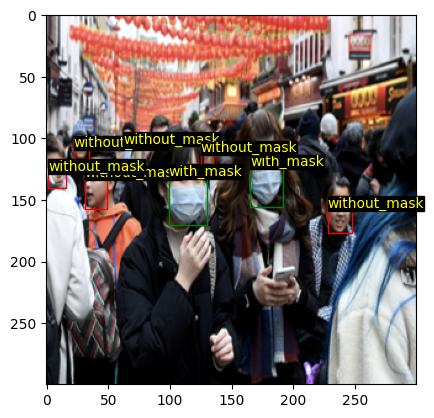

In [11]:
# Visualize one example
sample_image_data = preprocessed_data[2]['image']
sample_annotations = preprocessed_data[2]['annotations']
plt.imshow(sample_image_data)
for ann in sample_annotations:
    bbox = ann['bbox']
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                             linewidth=1, edgecolor='r' if ann['label'] == 'without_mask' else 'g',
                             facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(bbox[0], bbox[1], ann['label'], color='yellow', verticalalignment='top',
             bbox={'color': 'black', 'pad': 0})
plt.show()

In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Convert annotations to a suitable format for model training (e.g., one-hot encoding for labels)
labels = []
for data in preprocessed_data:
    # Example: Convert labels to one-hot encoded format
    # Modify this based on how you want to handle labels
    labels.append(1 if 'without_mask' in [ann['label'] for ann in data['annotations']] else 0)

In [14]:
# Prepare features and labels for the model
features = [data['image'] for data in preprocessed_data]
features = np.array(features)
labels = np.array(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [15]:
# Image augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [16]:
# Load a pre-trained VGG16 model as a base
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False  # Freeze the base model layers

58889256/58889256 [==============================] - 1s 0us/step


In [17]:
# Create the model
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Use 'softmax' for multiclass classification
# ])

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [18]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=10  # Adjust the number of epochs based on your requirement
)

Epoch 1/10
43/43 [==============================] - 631s 15s/step - loss: 0.6489 - accuracy: 0.6496 - val_loss: 0.5888 - val_accuracy: 0.6959
Epoch 2/10
43/43 [==============================] - 623s 15s/step - loss: 0.5700 - accuracy: 0.6891 - val_loss: 0.5659 - val_accuracy: 0.7076
Epoch 3/10
43/43 [==============================] - 598s 14s/step - loss: 0.5537 - accuracy: 0.7155 - val_loss: 0.5426 - val_accuracy: 0.6842
Epoch 4/10
43/43 [==============================] - 621s 15s/step - loss: 0.5373 - accuracy: 0.7258 - val_loss: 0.5673 - val_accuracy: 0.6959
Epoch 5/10
43/43 [==============================] - 599s 14s/step - loss: 0.5159 - accuracy: 0.7346 - val_loss: 0.5596 - val_accuracy: 0.7193
Epoch 6/10
43/43 [==============================] - 599s 14s/step - loss: 0.5374 - accuracy: 0.7273 - val_loss: 0.5485 - val_accuracy: 0.7193
Epoch 7/10
43/43 [==============================] - 601s 14s/step - loss: 0.4866 - accuracy: 0.7478 - val_loss: 0.5333 - val_accuracy: 0.7427
Epoch 